# HarvestStat Data Profiling - Ethiopia

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32637' # Ethiopia
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/ET_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Ethiopia',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, proxies={}, auth=auth)
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1994	 | ET1994A1 | 11	| ET1994A2	| 66	| nan	| 0	|
| 2001	 | ET2001A1 | 11	| ET2001A2	| 68	| nan	| 0	|
| 2003	 | ET2003A1 | 11	| ET2003A2	| 73	| nan	| 0	|
| 2007	 | ET2007A1 | 11	| ET2007A2	| 75	| nan	| 0	|
| 2008	 | ET2008A1 | 11	| ET2008A2	| 80	| nan	| 0	|
| 2014	 | ET2014A1 | 11	| ET2014A2	| 77	| nan	| 0	|
| 2019	 | ET2019A1 | 11	| ET2019A2	| 84	| nan	| 0	|
| 2020	 | ET2020A1 | 11	| ET2020A2	| 91	| nan	| 0	|
| 2021	 | ET2021A1 | 12	| ET2021A2	| 92	| nan	| 0	|
----------------------------------------------- #


In [3]:
#df[((df.fnid=='ET1994A20609')&(pd.to_datetime(df.period_date).dt.to_period('Y')=='2000'))]
df.loc[((df.fnid=='ET1994A20724')&(df['product']=='Maize (Corn)')&
    (df['indicator']=='Area Planted')&(df['status']=='Collected')&
    (pd.to_datetime(df.period_date).dt.to_period('Y')=='2000'))]

df.loc[((df.fnid=='ET1994A20724')&(df['product']=='Maize (Corn)')&
    (df['indicator']=='Area Planted')&(df['status']=='Collected')&
    (pd.to_datetime(df.period_date).dt.to_period('Y')=='2000')),'value']

6165    44000.0
Name: value, dtype: float64

In [4]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting
# a.1) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# a.2) Early in the record the catch-all crop production system is 'all' rather than none. Make these to none-type
df.loc[df['crop_production_system'] == 'all', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# ----------------------------------------------- #

#Drop the blank (nan) rows that are duplicates of rows that do have data
df=df[np.isfinite(df.value)]
#limit the data to admin 2 resolution
df=df.dropna(subset=['admin_2'])
rows = ['fnid','season_year', 'product','indicator','crop_production_system']

#The Maize Grain (Fresh) crop code only exists in 2020, when the yield issue was fixed, but there are now duplicates of the data
# drop the Maize (Corn) data in 2020, then rename the crop data for Maize Grain (Fresh) to Maize (corn)
df = df[~((df['product'] == 'Maize (Corn)')&(pd.to_datetime(df.period_date).dt.year==2020))]
df.loc[(df['product'] == 'Maize Grain (Fresh)'),'product'] = 'Maize (Corn)'

#Barley (White) only exists in years/areas where Barley (Unspecified) does not exist. Rename to a single Barley (Unspecified) class
df.loc[(df['product'] == 'Barley (White)'),'product'] = 'Barley (Unspecified)'

#Drop 2018 until it is fixed (incorrect conversion from quintals to tons I think)
df = df[~(pd.to_datetime(df.period_date).dt.to_period('Y')=='2018')]

## Note: I suspect the following two calues are actually the same thing

#drop observations from Kemashi in 2000. The only crop with data (sorghum) is missing ha, although it exists in the source doc
df = df[~((df.fnid=='ET1994A20609')&(pd.to_datetime(df.period_date).dt.to_period('Y')=='2000'))]


#replace a mistyped value of 44000 with 440 (confirmed with sourcr docs)
df.loc[((df.fnid=='ET1994A20724')&(df['product']=='Maize (Corn)')&
    (df['indicator']=='Area Planted')&(df['status']=='Collected')&
    (pd.to_datetime(df.period_date).dt.to_period('Y')=='2000')),'value']=440


# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# # FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([ET_Admin2_1994,ET_Admin2_2001,ET_Admin2_2003,ET_Admin2_2007,ET_Admin2_2008,ET_Admin2_2014,ET_Admin2_2019,ET_Admin2_2020], axis=0)
PlotAdminShapes(shape_used, label=True)
# # ----------------------------------------------- #


- Remove missing records ---------------------- #
Orignial data points: 46,627
Removed 813 "Missing Value" points
16,422/16,580 "Area Planted" points are retained.
14,801/15,044 "Quantity Produced" points are retained.
14,591/15,003 "Yield" points are retained.
Current data points: 45,814

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1998 - 2019
58 grain types are found: Avocado (Hass), Avocado (unspecified), Banana (unspecified), Barley (Unspecified), Beans (Red), Beans (White), Beans (mixed), Beet, Cabbage (Unspecified), Carrots, Chick Peas, Chili pepper (Unspecified), Coffee (unspecified), Enset, Ethiopian cabbage, Fava bean, Fenugreek, Field Peas, Garlic, Gibto, Grass Pea, Green Peppers, Groundnuts (In Shell), Guava (unspecified), Hops, Hot red pepper, Kabuli chick pea, Lemon (unspecified), Lentils, Lettuce (Unspecified), Linseed (unspecified), Maize (Corn), Mango (unspecified), Millet (Finger), Mixed Teff, Mung b

- Ethiopia crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-ethiopia.png?itok=xWM8Nlr6"  width=900><br>

<img src="https://www.fao.org/giews/countrybrief/country/ETH/graphics/1_2023-06-15.jpg"  width=900>

- comparison of boundaries

<img src="../figures/ET_admin_shapes.png"  width=900>

- In Ethiopia, basd on the FEWS NET data, there were admin unit changes in 1994, 2001, 2003, 2007, 2008, 2014, 2019, and 2020

| year	 | Admin1   | # units   | Admin2   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1994	 | ET1994A1 | 11	| ET1994A2	| 66	| nan	| 0	|
| 2001	 | ET2001A1 | 11	| ET2001A2	| 68	| nan	| 0	|
| 2003	 | ET2003A1 | 11	| ET2003A2	| 73	| nan	| 0	|
| 2007	 | ET2007A1 | 11	| ET2007A2	| 75	| nan	| 0	|
| 2008	 | ET2008A1 | 11	| ET2008A2	| 80	| nan	| 0	|
| 2014	 | ET2014A1 | 11	| ET2014A2	| 77	| nan	| 0	|
| 2019	 | ET2019A1 | 11	| ET2019A2	| 84	| nan	| 0	|
| 2020	 | ET2020A1 | 11	| ET2020A2	| 91	| nan	| 0	|

- There is a 2020 shapefile, but no data associated with it so we use 2019 as the most recent

In [5]:
# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = ET_Admin2_2019.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

ET1994A21706:	"North Shewa (OR)" (FDW) is changed to "North Shewa" (shapefile).
ET1994A20305:	"North Shewa (AM)" (FDW) is changed to "North Shewa" (shapefile).
ET2001A20406:	"North Shewa (OR)" (FDW) is changed to "North Shewa" (shapefile).
ET2001A20305:	"North Shewa (AM)" (FDW) is changed to "North Shewa" (shapefile).
ET2003A20406:	"North Shewa (OR)" (FDW) is changed to "North Shewa" (shapefile).
ET2003A20305:	"North Shewa (AM)" (FDW) is changed to "North Shewa" (shapefile).
ET2007A20406:	"North Shewa (OR)" (FDW) is changed to "North Shewa" (shapefile).
ET2007A20305:	"North Shewa (AM)" (FDW) is changed to "North Shewa" (shapefile).
ET2008A20406:	"North Shewa (OR)" (FDW) is changed to "North Shewa" (shapefile).
ET2008A20305:	"North Shewa (AM)" (FDW) is changed to "North Shewa" (shapefile).
ET2014A20305:	"North Shewa (AM)" (FDW) is changed to "North Shewa" (shapefile).
ET2014A20406:	"North Shewa (OR)" (FDW) is changed to "North Shewa" (shapefile).
ET2019A21202:	"Agniwak" (FDW) is changed

In [6]:
# Link admin boundaries ------------------------- #
link_1994, over_1994 = FDW_PD_CreateAdminLink(ET_Admin2_1994, ET_Admin2_2019, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2001, over_2001 = FDW_PD_CreateAdminLink(ET_Admin2_2001, ET_Admin2_2019, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2003, over_2003 = FDW_PD_CreateAdminLink(ET_Admin2_2003, ET_Admin2_2019, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2007, over_2007 = FDW_PD_CreateAdminLink(ET_Admin2_2007, ET_Admin2_2019, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2008, over_2008 = FDW_PD_CreateAdminLink(ET_Admin2_2008, ET_Admin2_2019, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2014, over_2014 = FDW_PD_CreateAdminLink(ET_Admin2_2014, ET_Admin2_2019, 'ADMIN2', 'ADMIN2', prod, epsg)

# Crop specific ratios
link_ratio_1994 = FDW_PD_RatioAdminLink(link_1994, prod, over_1994, mdx_pss)
link_ratio_2001 = FDW_PD_RatioAdminLink(link_2001, prod, over_2001, mdx_pss)
link_ratio_2003 = FDW_PD_RatioAdminLink(link_2003, prod, over_2003, mdx_pss)
link_ratio_2007 = FDW_PD_RatioAdminLink(link_2007, prod, over_2007, mdx_pss)
link_ratio_2008 = FDW_PD_RatioAdminLink(link_2008, prod, over_2008, mdx_pss)
link_ratio_2014 = FDW_PD_RatioAdminLink(link_2014, prod, over_2014, mdx_pss)

# Merge link_ratio
assert link_ratio_1994.keys() == link_ratio_2014.keys()
assert link_ratio_2001.keys() == link_ratio_2014.keys()
assert link_ratio_2003.keys() == link_ratio_2014.keys()
assert link_ratio_2007.keys() == link_ratio_2014.keys()
assert link_ratio_2008.keys() == link_ratio_2014.keys()

link_merged = [link_ratio_1994, link_ratio_2001,link_ratio_2003,link_ratio_2007,link_ratio_2008, link_ratio_2014]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #


CBR is considered for 'ET1994A21728' as no record found in: ['ET2019A20415']
CBR is considered for 'ET1994A20201' as no record found in: ['ET2019A20201']
CBR is considered for 'ET1994A20202' as no record found in: ['ET2019A20202']
CBR is considered for 'ET1994A21501' as no record found in: ['ET2019A21501']
CBR is considered for 'ET1994A21410' as no record found in: ['ET2019A21401']
CBR is considered for 'ET2001A20426' as no record found in: ['ET2019A20415']
CBR is considered for 'ET2001A20201' as no record found in: ['ET2019A20201']
CBR is considered for 'ET2001A20202' as no record found in: ['ET2019A20202']
CBR is considered for 'ET2001A21501' as no record found in: ['ET2019A21501']
CBR is considered for 'ET2001A21410' as no record found in: ['ET2019A21401']
CBR is considered for 'ET2003A20201' as no record found in: ['ET2019A20201']
CBR is considered for 'ET2003A20202' as no record found in: ['ET2019A20202']
CBR is considered for 'ET2003A21501' as no record found in: ['ET2019A21501']

In [7]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = crop_new.T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Manual change of product name
product_category_custom = {
    'Avocado (Hass)': 'Avocado (Hass)',
    'Avocado (unspecified)': 'Avocado (unspecified)',
    'Banana (unspecified)': 'Banana',
    'Barley (Unspecified)': 'Barley',
    'Beans (Red)': 'Beans (Red)',
    'Beans (White)': 'Beans (White)',
    'Beans (mixed)': 'Beans (mixed)',
    'Beet': 'Beet',
    'Cabbage (Unspecified)': 'Cabbage',
    'Carrots': 'Carrots',
    'Chick Peas': 'Chick Peas',
    'Enset': 'Enset',
    'Ethiopian cabbage': 'Ethiopian cabbage',
    'Fava bean': 'Fava bean',
    'Fenugreek': 'Fenugreek',
    'Field Peas': 'Field Peas',
    'Garlic': 'Garlic',
    'Gibto': 'Gibto',
    'Grass Pea': 'Grass Pea',
    'Green Peppers': 'Green Peppers',
    'Groundnuts (In Shell)': 'Groundnuts (In Shell)',
    'Guava (unspecified)': 'Guava',
    'Kabuli chick pea': 'Kabuli chick pea',
    'Lemon (unspecified)': 'Lemon',
    'Lentils': 'Lentils',
    'Lettuce (Unspecified)': 'Lettuce',
    'Linseed (unspecified)': 'Linseed',
    'Maize (Corn)': 'Maize',
    'Mango (unspecified)': 'Mango',
    'Millet (Finger)': 'Millet',
    'Mixed Teff': 'Teff',
    'Mung bean (unspecified)': 'Mung bean',
    'Neug': 'Neug',
    'Oats (Unspecified)': 'Oats',
    'Onions': 'Onions',
    'Orange (unspecified)': 'Orange',
    'Papaya (unspecified)': 'Papaya',
    'Pineapple (unspecified)': 'Pineapple',
    'Potato (unspecified)': 'Potato',
    'Rape': 'Rape',
    'Rice (Paddy)': 'Rice',
    'Safflower Seed': 'Safflower Seed',
    'Sesame Seed': 'Sesame Seed',
    'Sorghum': 'Sorghum',
    'Soybean (unspecified)': 'Soybean',
    'Sugarcane (for sugar)': 'Sugarcane',
    'Sunflower Seed': 'Sunflower Seed',
    'Sweet Potatoes': 'Sweet Potatoes',
    'Swiss Chard': 'Swiss Chard',
    'Taro/Cocoyam (Unspecified)': 'Taro/Cocoyam',
    'Tomato': 'Tomato',
    'Vetch': 'Vetch',
    'Wheat Grain': 'Wheat',
    'Yams': 'Yams',
    'Hot red pepper': 'Hot red pepper', 
    'Hops': 'Hops', 
    'Chili pepper (Unspecified)': 'Cili pepper',
    'Coffee (unspecified)': 'Coffee'
}
assert set(stack['product'].unique()) == set(product_category_custom.keys())
stack['product'] = stack['product'].replace(product_category_custom)
for f, r in link_ratio.items():
    mdx = pd.MultiIndex.from_frame(r.index.to_frame().reset_index(drop=True).replace(product_category_custom))
    r.index = mdx
    link_ratio[f] = r
# Calibration of crop calendar using External Crop Calendar (ECC)
ecc = pd.read_csv('../data/crop_calendar/external_crop_calendar.csv')
ecc = ecc[ecc['country'] == 'Ethiopia']
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, ecc, link_ratio)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

# Save data
fn_out = '../data/crop/adm_crop_production_ET.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_ET_ratio.npz', link_ratio)

All [season_name, product, crop_production_system] are in the external crop calendar.
../data/crop/adm_crop_production_ET.csv is saved.
../data/crop/adm_crop_production_ET_ratio.npz is saved.


# Visualization of production data

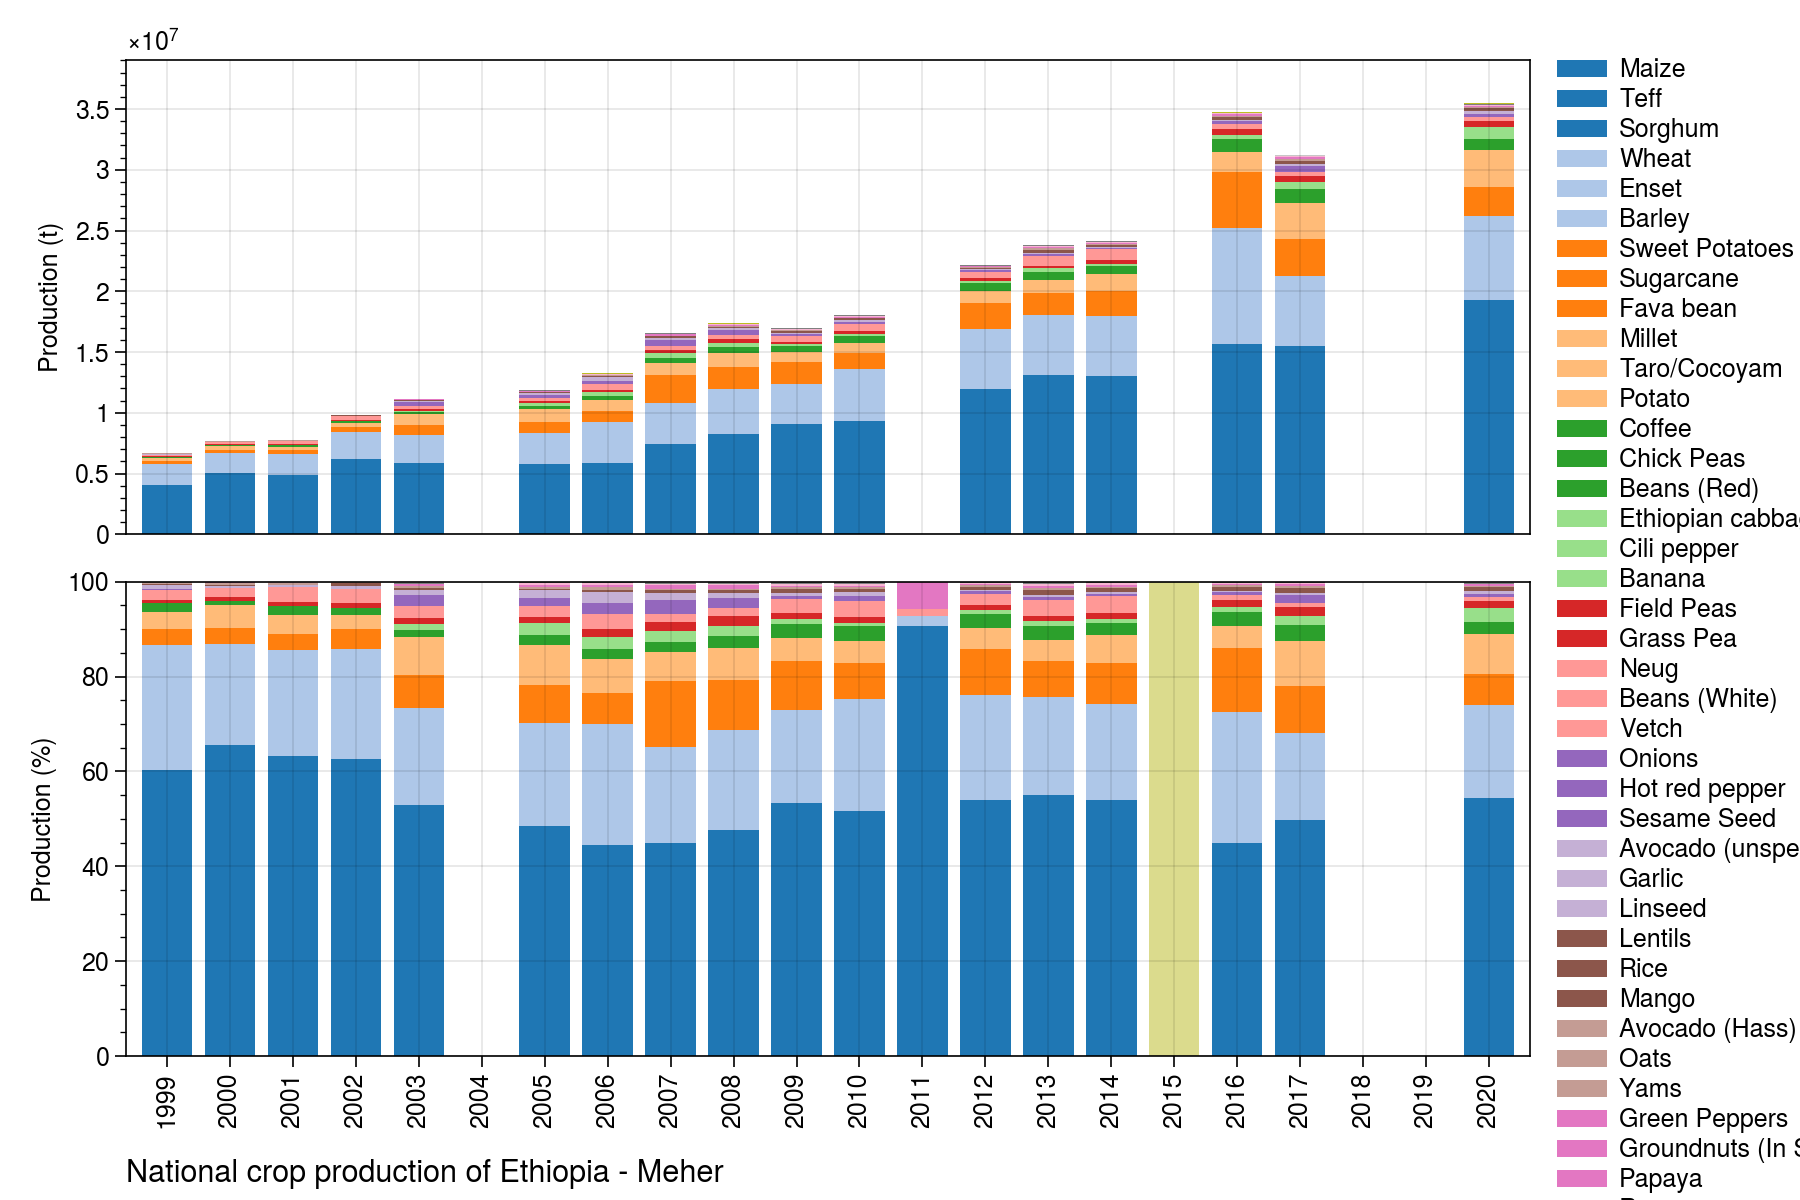

../figures/ET_bar_natgrainprod_Meher.png is saved.


In [8]:
# Bar chart of national crop production
country_iso, country_name = 'ET', 'Ethiopia'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Meher']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

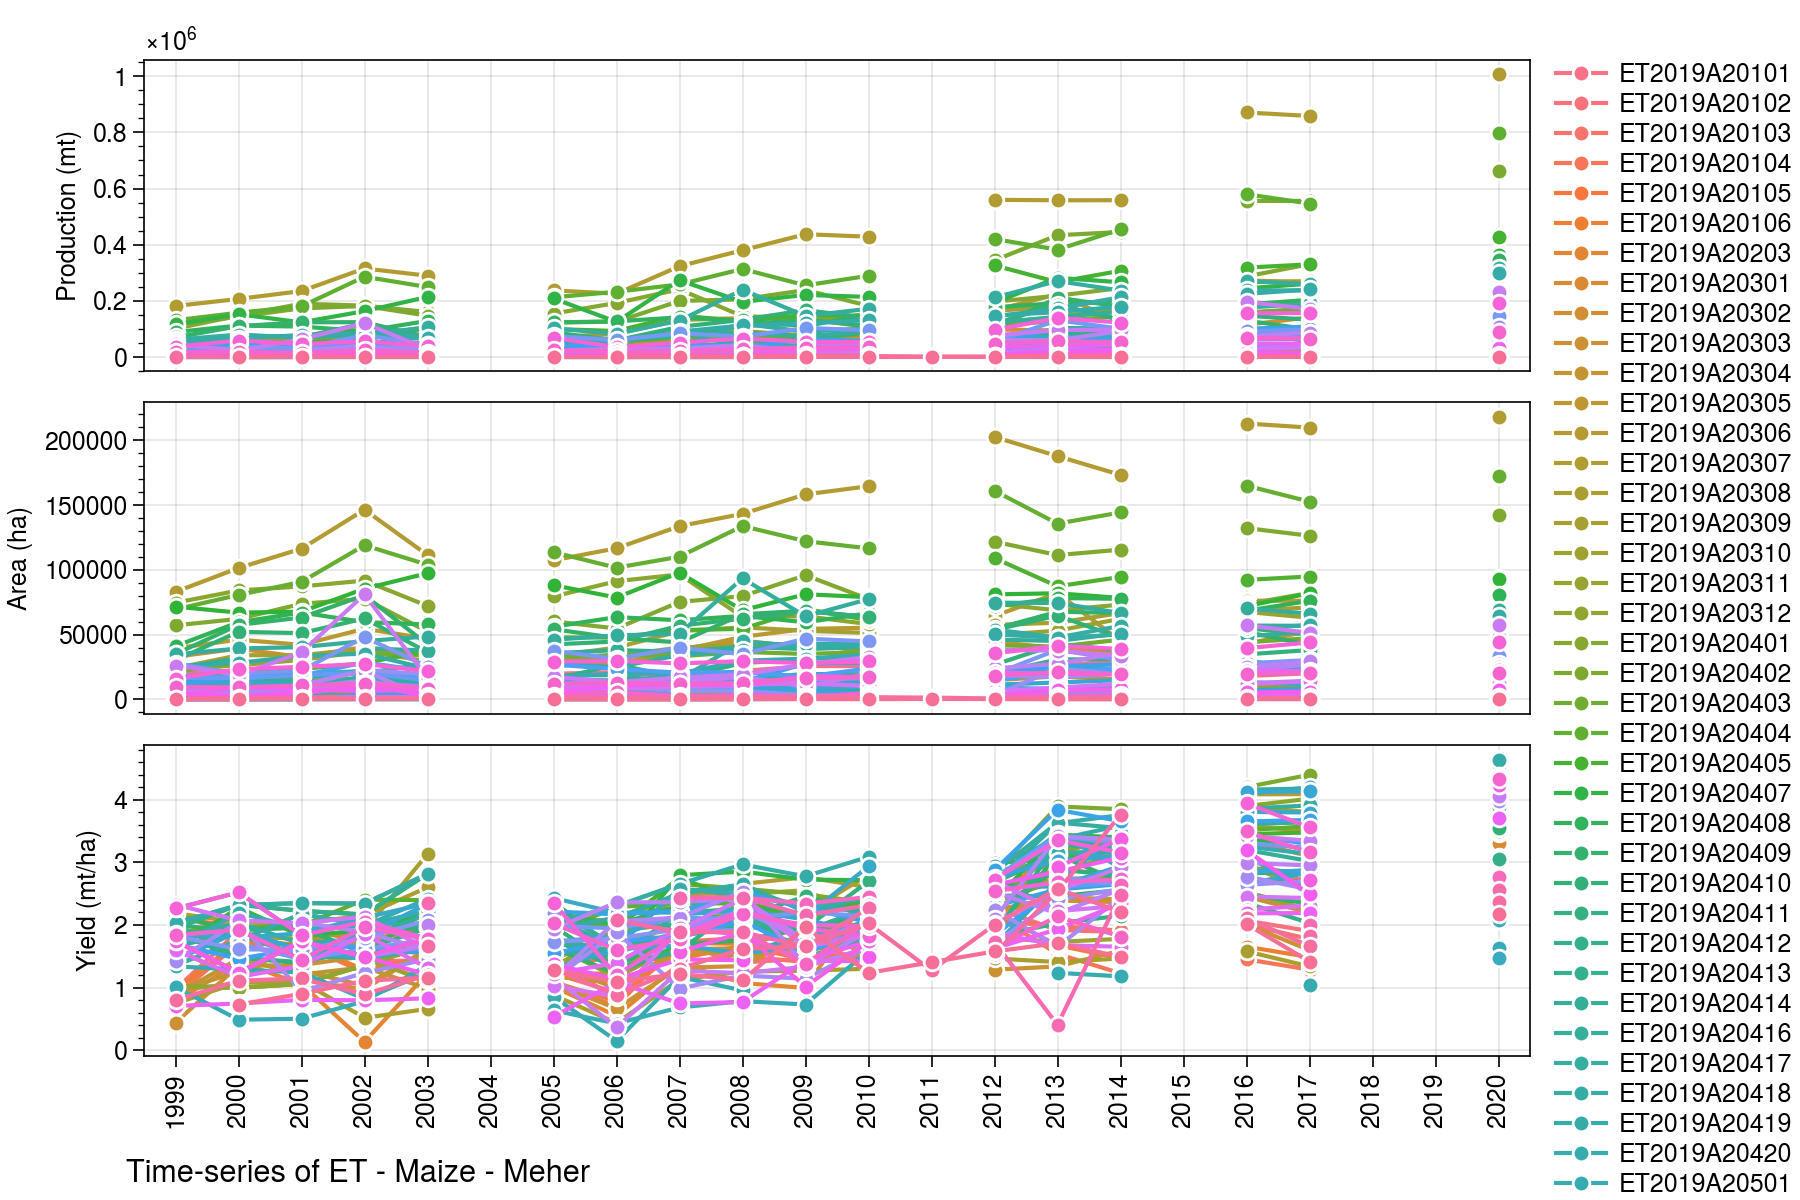

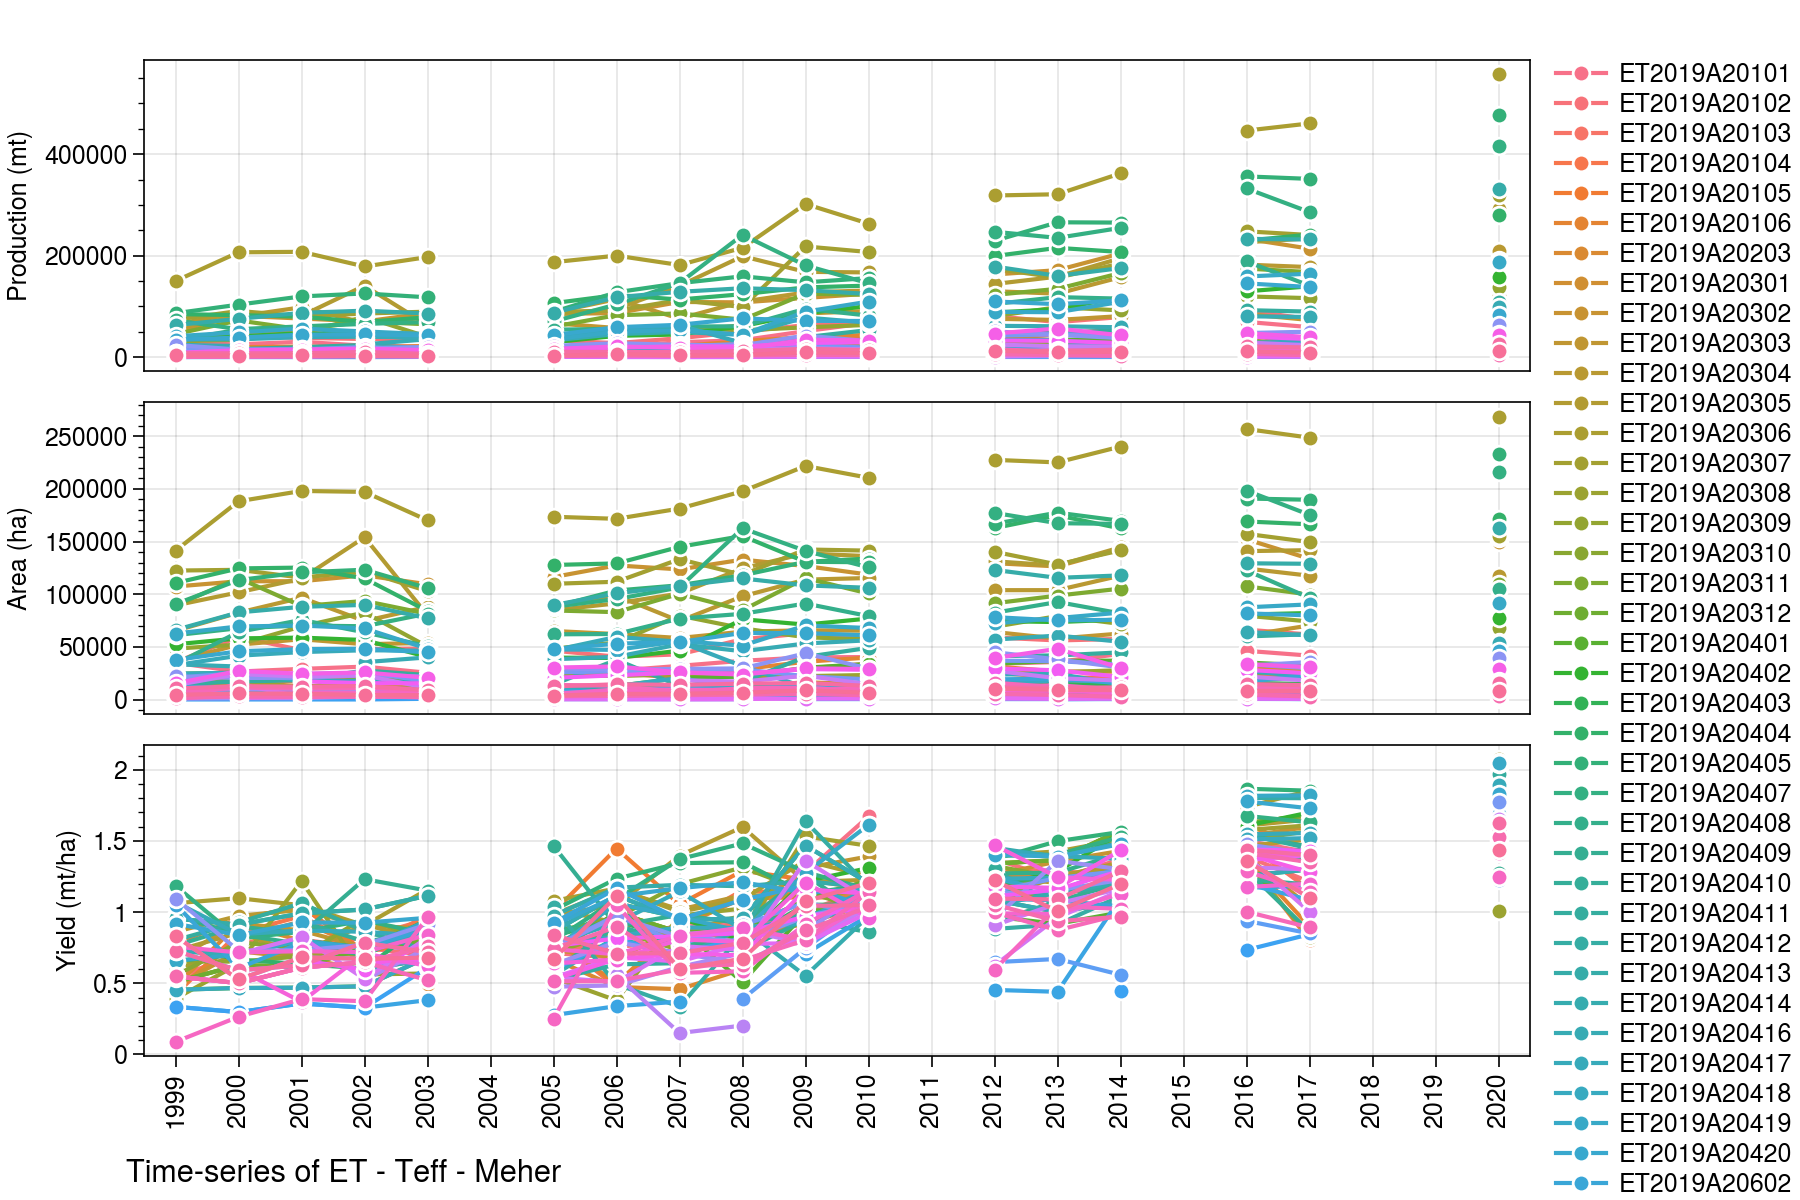

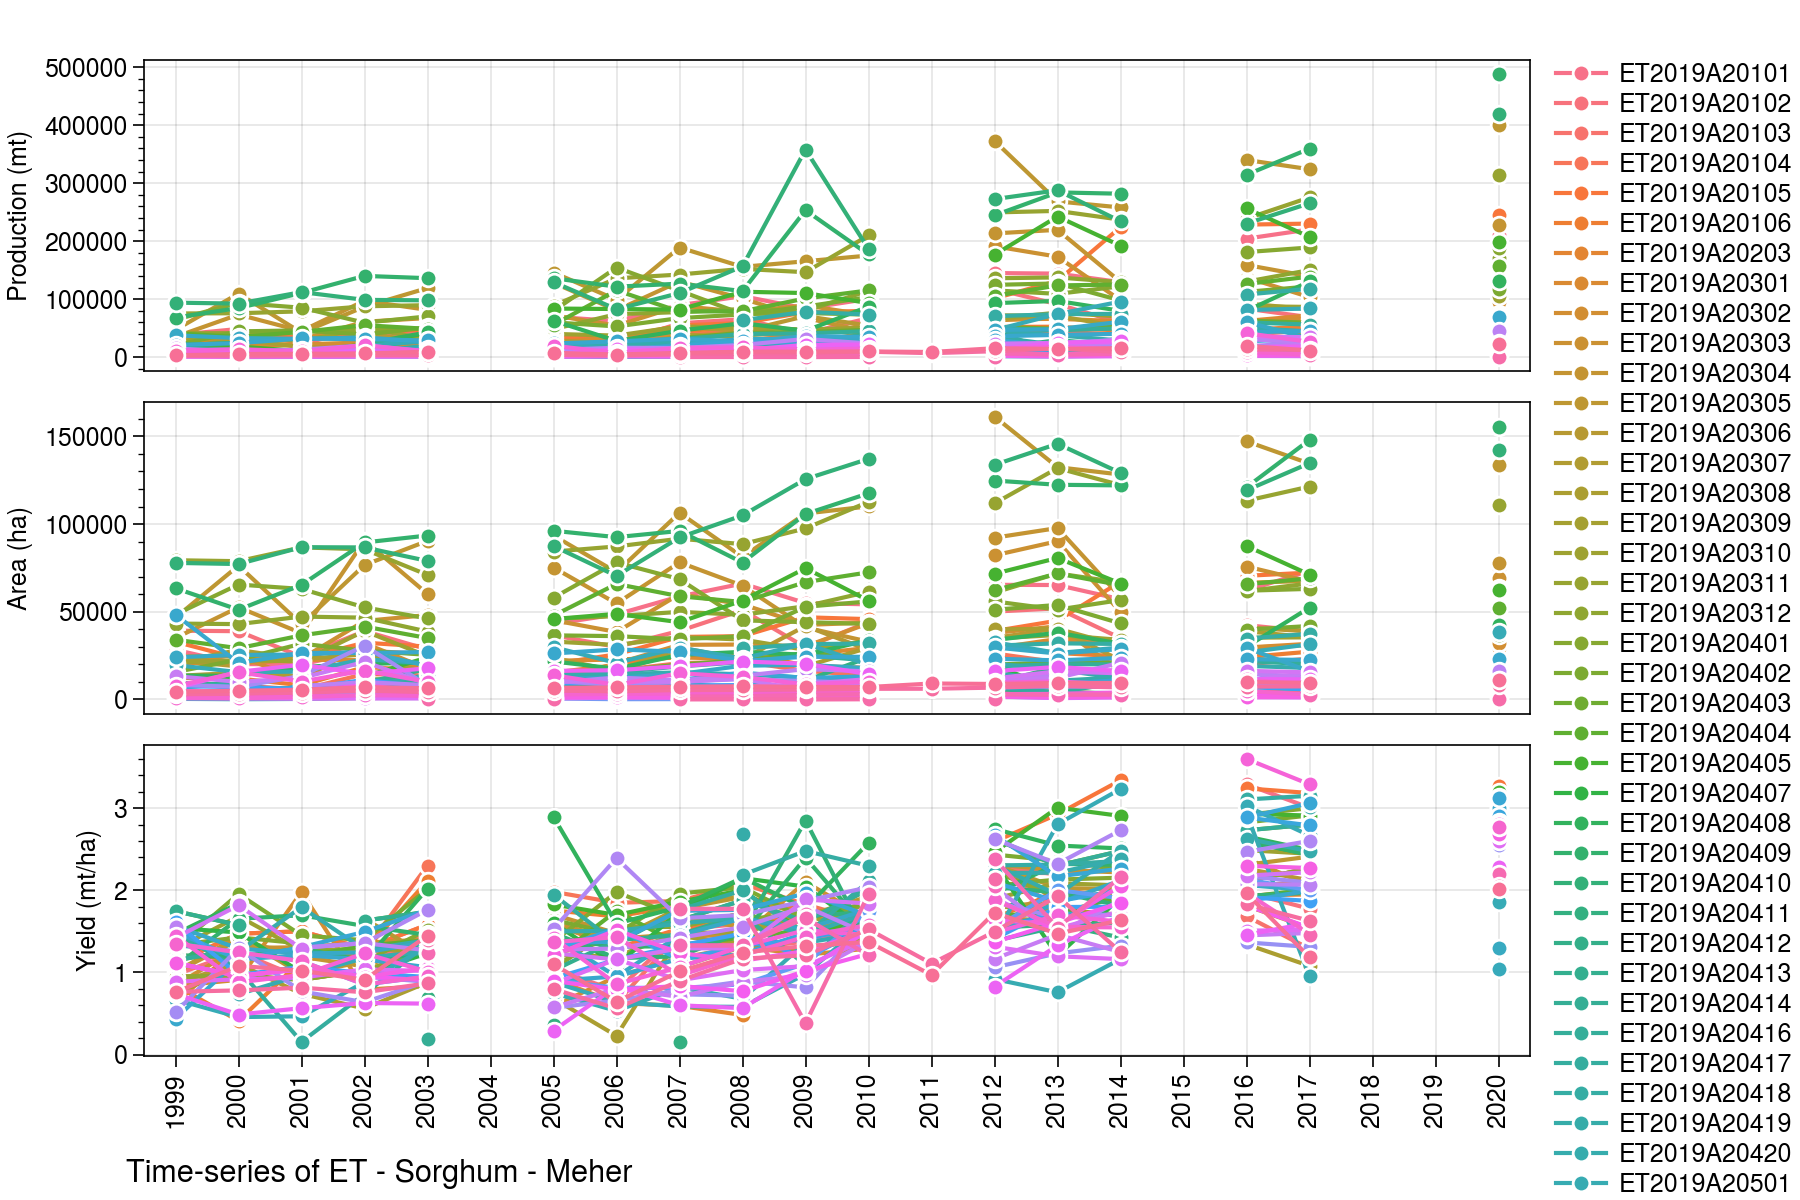

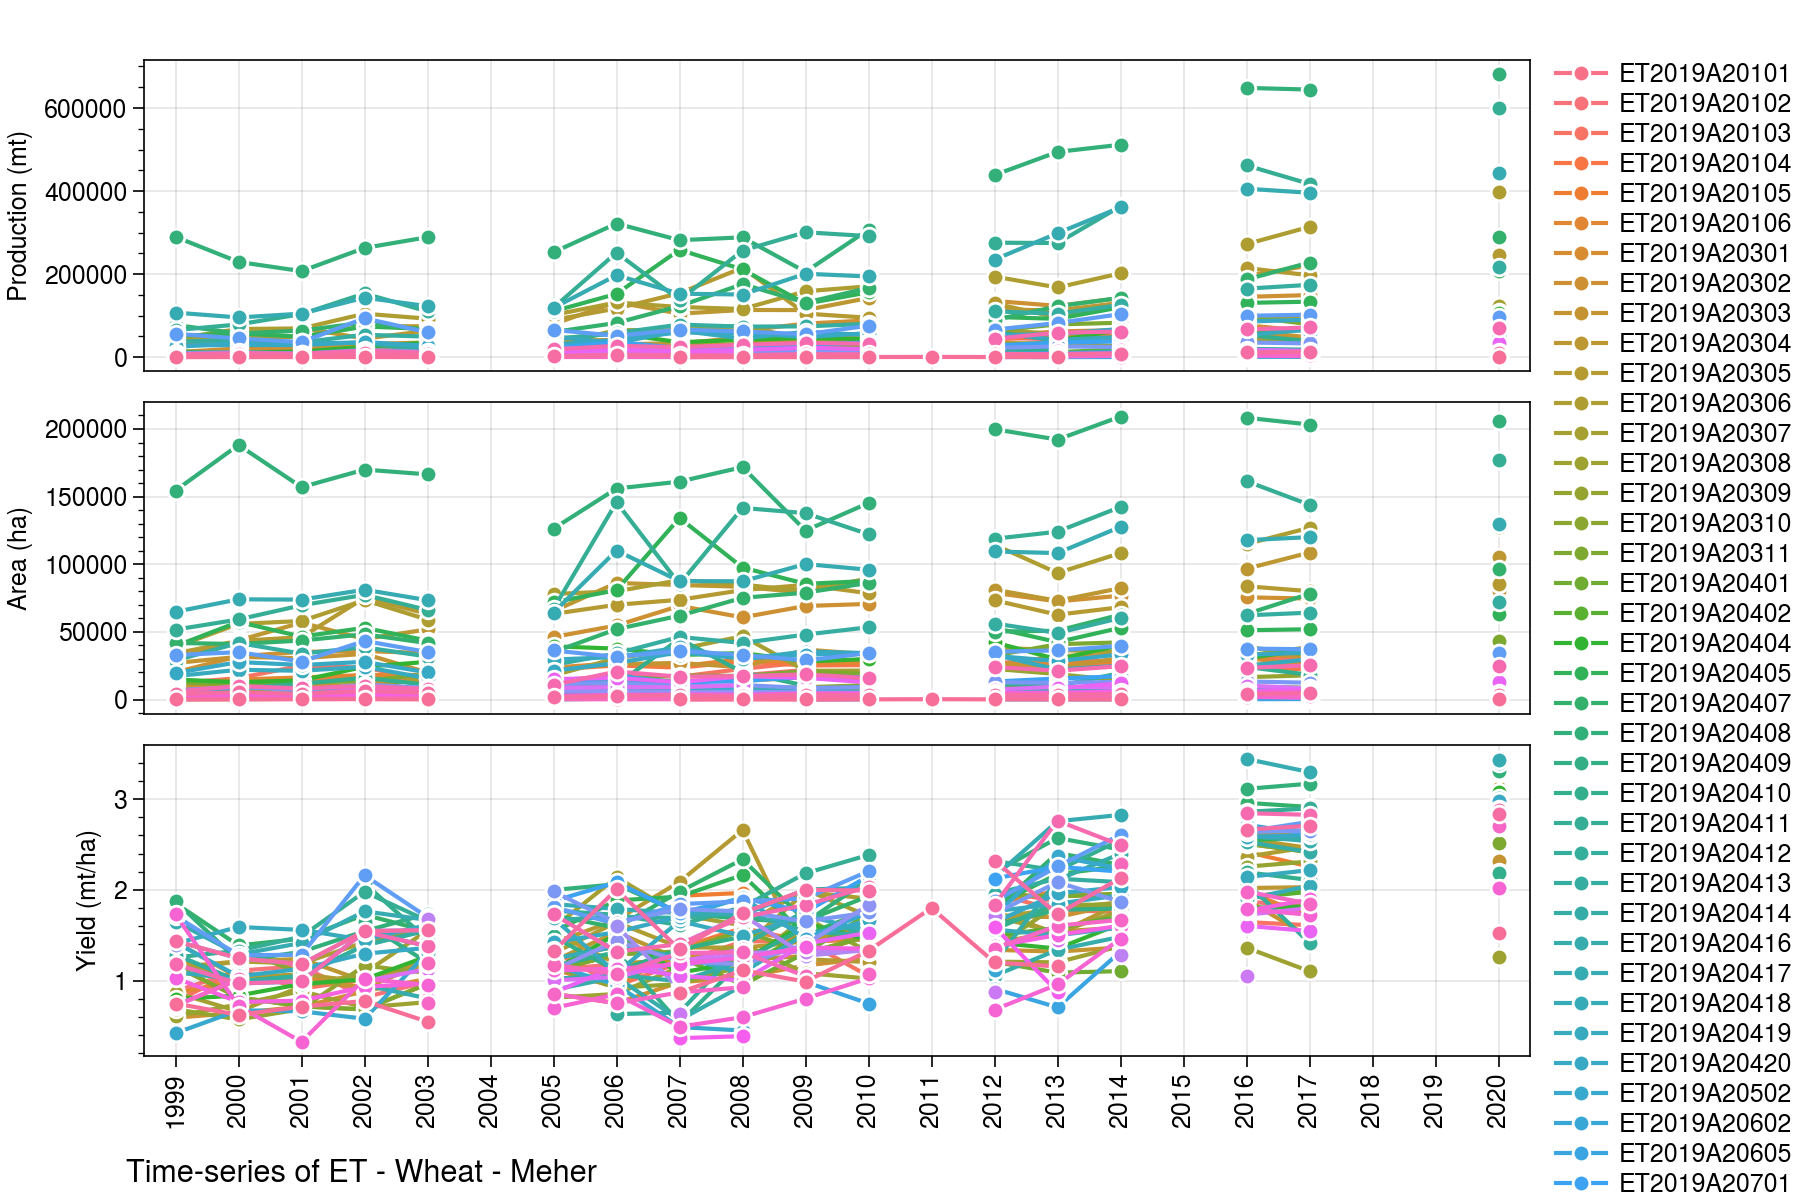

In [9]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'ET', 'Ethiopia'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Maize', 'Meher'],
    ['Teff', 'Meher'],
    ['Sorghum', 'Meher'],
    ['Wheat', 'Meher'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)